In [1]:
# Hide raw notebook code in exported HTML
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show) {
   $('div.input').hide();
 } else {
   $('div.input').show();
 }
 code_show = !code_show
} 
$(document).ready(code_toggle);
</script>
<form><input type="button" value="Return home" onclick="location.href='https://mlnoga.github.io/covid19-analysis/'"></input>
<input type="button" value="Show/hide code" onclick="code_toggle()"></input></form>

<!-- Global site tag (gtag.js) - Google Analytics -->
<script async src="https://www.googletagmanager.com/gtag/js?id=UA-161715363-1"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-161715363-1');
</script>
''')

# Covid-19 Data Analysis April 3rd

On the global level, exponential growth continues. Daily percentage increases in cases are slowly trending down, while daily percentage increases in fatalities are trending up. The crude case fatality ratio (CFR) also continues to trend upwards. Crude CFR measures the number of cumulative deaths, divided by the cumulative number of cases.

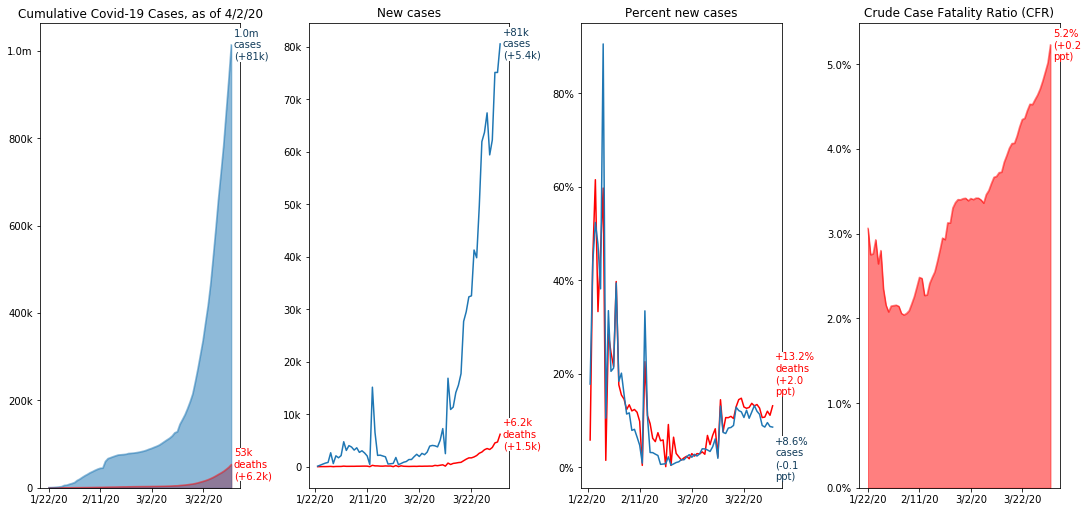

In [2]:
# Import required libraries
###########################

import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning
from scipy.special import expit

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

import datetime as datetime
import operator
import sys
import warnings
import math


# Data management
#################

# Load data, drop unneeded lat/long columns and group by country/region
def loadAndGroup(fileName, groupBy="Country/Region", dropColumns=["Lat", "Long"]):
    df=pd.read_csv(fileName)
    for dc in dropColumns:
        df.drop(dc, axis=1, inplace=True)
    df=df.groupby(groupBy).sum()
    return df

# Retrieve data for one country from the data frame
def getData(df, name):
    df1   =df.loc[name]
    days  =df1.index.values
    days  =[datetime.datetime.strptime(d,"%m/%d/%y").date() for d in days]
    daynr =np.array(range(1, len(days)+1))
    values=df1.to_numpy()
    return days, daynr, values

# Load data
confd =loadAndGroup('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths=loadAndGroup('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
#confd =loadAndGroup('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
#deaths=loadAndGroup('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
population=loadAndGroup('./population.csv','Country', dropColumns=[])
today =confd.columns[-1]

# Calculate new, previous and total as well as growth rate from time series
def newPrevTotalGrowth(df):
    df1        =df.loc[:, df.columns[-2]:]
    prev, total=df1.sum(axis=0)
    delta      =total-prev
    return delta, prev, total, delta/prev if prev!=0 else 0

# Calculate overall data sets for overview plots
confdNew,  confdPrev,  confdTotal,  confdGrowth =newPrevTotalGrowth(confd)
deathsNew, deathsPrev, deathsTotal, deathsGrowth=newPrevTotalGrowth(deaths)

# Calculate last growth rate of a data series
def lastGrowth(data):
    if len(data)>=2 and data[-2]>0:
        return data[-1]/data[-2]-1
    return 0    

# Calculate daily increment of a data series
def diff(ys):
    res=[0]
    cur=ys[0]
    for y in ys[1:]:
        res.append(y-cur)
        cur=y
    return res


# Formatting
############

# Format to three significant digits
def s3(x):
    return np.around(x,decimals=3)

# Human readable formatting for figures ranging in single digits, thousands, millions and billions
def humanReadable(x, plus=False):
    if math.isnan(x):
        return "NaN"
    if x<0:
        return "-"+humanReadable(-x, plus=False)
    if plus:
        return "+"+humanReadable(x, plus=False)
    if x==0:
        return "0"
    formats=[ (10000000000, 1000000000,"%.0fb"), (1000000000,1000000000, "%.1fb"), (10000000, 1000000, "%.0fm"), 
             (1000000, 1000000, "%.1fm"), (10000,1000,"%.0fk"), (1000,1000,"%.1fk"), (10,1, "%d"), (0,1, "%.1f") ]
    for threshold, divider, formatString in formats:
        if x>=threshold:
            return formatString % (x/divider)

@plticker.FuncFormatter
def hrFormatter(x, pos):
    return humanReadable(x)

# Label last datapoint of a series
def labelLast(ax, x, y, c='tab:blue', va='center', weight='normal'):
    if y[-1]>0:
        ax.annotate(humanReadable(y[-1]), (x[-1],y[-1]), (2,0), textcoords='offset pixels', ha='left', va=va, c=c, weight=weight, bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Adjust the lightness of a given color        
def adjustLightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])        


# Global overview plot
######################

# Plot overview
fig, axs=plt.subplots(figsize=[15, 7], nrows=1, ncols=4, constrained_layout=True)
colors=['r', 'tab:blue']

# Left: Cases
ax=axs[0]
globalConfd =confd.sum(axis=0)
globalDeaths=deaths.sum(axis=0)
globalDF=pd.DataFrame({
    'Deaths':globalDeaths, 
    'Confirmed':globalConfd
})
globalDF.plot(ax=ax, kind='area', stacked=False, color=colors)
ax.set_title("Cumulative Covid-19 Cases, as of %s" % today, fontsize=12)
ax.yaxis.set_major_formatter(hrFormatter)
ax.get_legend().remove()

# Label the last values
xPos=len(globalConfd.index)-1
x, prevX=globalConfd.index[xPos], globalConfd.index[xPos-1]
c, prevC=globalConfd[x], globalConfd[prevX]
d, prevD=globalDeaths[x], globalDeaths[prevX]
ax.text(xPos+1, d, "%s\ndeaths\n(%s)" %  (humanReadable(d), humanReadable(d-prevD, plus=True)), ha='left', va='center', c=colors[0], bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
_=ax.text(xPos+1, c, "%s\ncases\n(%s)" % (humanReadable(c), humanReadable(c-prevC, plus=True)), ha='left', va='center', c=adjustLightness(colors[1]), bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))


# Mid-left: Absoulte growth
ax=axs[1]
globalConfdDelta =globalConfd.diff()
globalDeathsDelta=globalDeaths.diff()
globalDFDelta=pd.DataFrame({
    'DeathsDelta':globalDeathsDelta, 
    'ConfirmedDelta':globalConfdDelta
})
globalDFDelta.plot(ax=ax, kind='line', stacked=False, color=colors)
ax.set_title("New cases", fontsize=12)
ax.yaxis.set_major_formatter(hrFormatter)
ax.get_legend().remove()

# Label the last values
c, prevC=globalConfdDelta[x], globalConfdDelta[prevX]
d, prevD=globalDeathsDelta[x], globalDeathsDelta[prevX]
ax.text(xPos+1, d, "+%s\ndeaths\n(%s)" % (humanReadable(d), humanReadable(d-prevD, plus=True)), ha='left', va='center', c=colors[0], bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
_=ax.text(xPos+1, c, "+%s\ncases\n(%s)" % (humanReadable(c), humanReadable(c-prevC, plus=True)), ha='left', va='center', c=adjustLightness(colors[1]), bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))


# Mid-right: Percentage growth
ax=axs[2]
globalConfdDeltaPerc =globalConfdDelta /globalConfd.shift(periods=1)
globalDeathsDeltaPerc=globalDeathsDelta/globalDeaths.shift(periods=1)
globalDFDeltaPerc=pd.DataFrame({
    'DeathsDeltaPerc':globalDeathsDeltaPerc, 
    'ConfirmedDeltaPerc':globalConfdDeltaPerc
})
globalDFDeltaPerc.plot(ax=ax, kind='line', stacked=False, color=colors)
ax.set_title("Percent new cases", fontsize=12)
ax.yaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax.get_legend().remove()

# Label the last values
c, prevC=globalConfdDeltaPerc[x], globalConfdDeltaPerc[prevX]
d, prevD=globalDeathsDeltaPerc[x], globalDeathsDeltaPerc[prevX]
ax.text(xPos+1, d+0.02, "%+.1f%%\ndeaths\n(%+.1f\nppt)" % (d*100, (d-prevD)*100), ha='left', va='bottom', c=colors[0], bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
_=ax.text(xPos+1, c-0.02, "%+.1f%%\ncases\n(%+.1f\nppt)" % (c*100, (c-prevC)*100), ha='left', va='top', c=adjustLightness(colors[1]), bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))


# Right: CFR
ax=axs[3]
globalCrudeCFR=globalDeaths/globalConfd
globalDFCrudeCFR=pd.DataFrame({'Crude CFR':globalCrudeCFR})
globalCrudeCFR.plot(ax=ax, kind='area', stacked=False, color=colors)
ax.set_title("Crude Case Fatality Ratio (CFR)", fontsize=12)
ax.yaxis.set_major_formatter(plticker.PercentFormatter(1.0))

# Label the last values
cfr, prevCfr=globalCrudeCFR[x], globalCrudeCFR[prevX]
ax.text(xPos+1, cfr, "%.1f%%\n(%+.1f\nppt)" % (cfr*100, (cfr-prevCfr)*100), ha='left', va='center', c=colors[0], bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
plt.show()

## Country Overview

With 243k confirmed cases, the US continues to report the most cumulative cases. Italy has passed Spain, and Germany has passed China as predicted yesterday. Percentage growth rates are highest in the US, Canada, Turkey and Brazil aound 15%. Spain and Germany around 7-9%. Italy and France have come down to some 4%. Among major western countries, Spain stands out with almost 240 cases per 100k population, followed by Switzerland Italy.

Italy stands at the 14k deaths mark, Spain at 10k. The US with almost 6k continue to grow fast.

Crude case fatality rates (CFR), measured as number of fatal outcomes per number of confirmed cases, continue to climb in Italy with 12%. Spain, France, the Netherlands and the UK remain in the 7-9% range. The comparatively low CFR in Germany again went up by 0.1 ppt to 1.3%, following an a weeklong pattern. This more and more seems to indicate that lower German figures might be largely due to an earlier stage of the epidemic in the country, detected because of vigorous testing. The US stands at 2.4%, up 0.2ppt from yesterday.

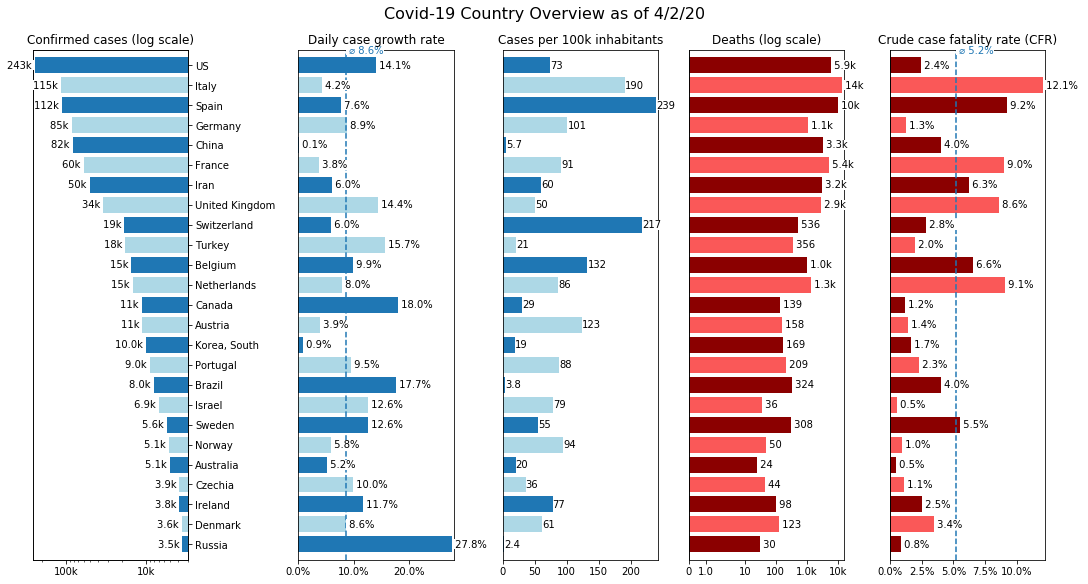

In [3]:
# Country overview plot
#######################

# Calculate summary stats for all countries with number of cases above the threshold
threshold=100
validCountries=[]
for name in confd.index.values:
    confv=confd.loc[name].to_numpy() 
    if confv[-1]>=threshold:
        deathv=deaths.loc[name].to_numpy()
        summary={
            'Name':name,
            'Cases':confv[-1],
            'CaseGrowth':lastGrowth(confv),
            'Deaths':deathv[-1],
            'DeathsGrowth':lastGrowth(deathv),
            'CrudeCFR':deathv[-1]/confv[-1],
        }
        validCountries.append(summary)

# Prepare sorted stats, and limit to top countries
validCountries.sort(key=lambda x: x['Cases'], reverse=True)
validCountries=validCountries[:25]

# Prepare data for plots
countryNames=[x['Name'] for x in validCountries]
countryCases=[x['Cases'] for x in validCountries]
countryGrowth=[x['CaseGrowth'] for x in validCountries]
countryDeaths=[x['Deaths'] for x in validCountries]
countryCrudeCFR=[x['CrudeCFR'] for x in validCountries]
countryPop1000=[population.loc[x]['PopulationInThousands'] for x in countryNames]
countryCasesPerPop1000=[cases/pop if pop!=0 else 0 for cases, pop in zip(countryCases, countryPop1000)]

# Prepare overview plot
fig, ax=plt.subplots(nrows=1, ncols=5, figsize=[15,8], constrained_layout=True)
fig.suptitle('Covid-19 Country Overview as of %s' % today, fontsize="16")
alternatingColorsCases=['tab:blue','lightblue']*int(len(countryNames)/2)
alternatingColorsDeaths=['darkred','#fa5858']*int(len(countryNames)/2)

# Left hand side: Plot lastest confirmed cases by country
ax[0].set_xscale('log')
ax[0].set_title('Confirmed cases (log scale)')
ax[0].get_yaxis().set_visible(False)
ax2 = ax[0].twinx()
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.xaxis.set_major_formatter(hrFormatter)
ax2.margins(0.015)
ax2.barh(countryNames, countryCases, color=alternatingColorsCases)
for i, v in enumerate(countryCases):
    ax2.text(v, i, "%s " % humanReadable(v), ha='right', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Middle left: Plot latest growth rate by country
ax[1].set_title('Daily case growth rate')
ax[1].invert_yaxis()
ax[1].get_yaxis().set_visible(False)
ax[1].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[1].margins(0.015)
ax[1].barh(countryNames, countryGrowth, color=alternatingColorsCases)
for i, v in enumerate(countryGrowth):
    ax[1].text(v, i, " %.1f%%" % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Middle: Plot cases per 1000 population
ax[2].set_title('Cases per 100k inhabitants')
ax[2].invert_yaxis()
ax[2].get_yaxis().set_visible(False)
ax[2].xaxis.set_major_formatter(hrFormatter)
ax[2].margins(0.015)
countryCasesPerPop100k=np.array(countryCasesPerPop1000)*100
ax[2].barh(countryNames, countryCasesPerPop100k, color=alternatingColorsCases)
for i, v in enumerate(countryCasesPerPop100k):
    ax[2].text(v, i, hrFormatter(v), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

line =ax[1].axvline(x=confdGrowth, ymin=0, ymax=len(countryNames), ls="--")
ax[1].text(confdGrowth, -0.75, " \u2300 %.1f%%" % (confdGrowth*100), ha='left', va='center', color=line.get_color(), bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Middle right: Plot deaths by country
ax[3].set_title('Deaths (log scale)')
ax[3].invert_yaxis()
ax[3].get_yaxis().set_visible(False)
ax[3].set_xscale('symlog')
ax[3].xaxis.set_major_formatter(hrFormatter)
ax[3].axvline(x=0, ymin=0, ymax=len(countryNames), color='k', ls='-', lw='.8')
ax[3].margins(0.015)
ax[3].barh(countryNames, countryDeaths, color=alternatingColorsDeaths)
for i, v in enumerate(countryDeaths):
    if v!=0:
        ax[3].text(v, i, " %s " % humanReadable(v), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Right: Plot CFR by country
ax[4].set_title('Crude case fatality rate (CFR)')
ax[4].invert_yaxis()
ax[4].get_yaxis().set_visible(False)
ax[4].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[4].axvline(x=0, ymin=0, ymax=len(countryNames), color='k', ls='-', lw='.8')
ax[4].margins(0.015)
ax[4].barh(countryNames, countryCrudeCFR, color=alternatingColorsDeaths)
for i, v in enumerate(countryCrudeCFR):
    if v!=0:
        ax[4].text(v, i, " %.1f%% " % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

line =ax[4].axvline(x=deathsTotal/confdTotal, ymin=0, ymax=len(countryNames), ls="--")
ax[4].text(deathsTotal/confdTotal, -0.75, " \u2300 %.1f%%" % (deathsTotal/confdTotal*100), ha='left', va='center', color=line.get_color(), bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

plt.show()


## Time-shifted Country View

These charts show the growth of confirmed cases by country. To make developments more comparable across countries, each country curve is shifted in time so that day 0 corresponds to the moment when that country exceeds a threshold number of confirmed cases (here=100). 

From reported numbers, containment and mitigation appear to be most effective in China, South Korea and Japan. Norway and Sweden have also flattened the curve somewhat. Germany continues to track the frightening trajectory of Italy closely. Measures taken in Spain and the US so far have resulted in a steeper trajectory than in Italy.

The picture for time-shifted deaths is similar. China and Iran have flattened. Italy is hardest hit and may be in the early stages of flattening. The US, France and the UK continue to track Italy. Spain is on an even steeper curve.  

Italy shows by far the highest CFR. Spain, the Netherlands and the UK are following the trajectory. CFRs in Iran are trending downwards for a week now. So far, Germany, Switzerland, South Korea and the US appear to display markedly lower CFRs than the bulk of the western countries. However, the ratio of fatal outcomes in these countries is trending slowly upwards.

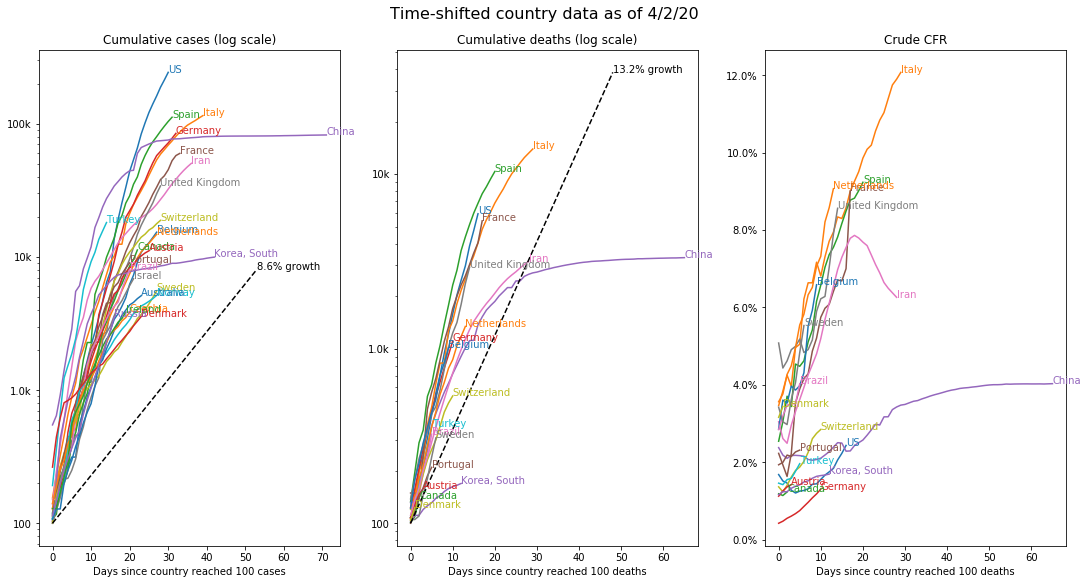

In [4]:
# Time-shifted countries plot
#############################

# Crop away starting values < n from the arrays
def startAtN(values, n):
    while(len(values)>0 and values[0]<n):
        values=values[1:]
    return values

# Plot an exponential growth line with given start value and factor
def plotFactor(ax, start,factor,length):
    xs=range(0, length)
    ys=[start]
    while(len(ys)<length):
        ys.append(factor*ys[-1])

    line, =ax.plot(xs, ys,"--k")
    c=line.get_color()
    ax.text(xs[-1], ys[-1], "%.1f%% growth" % (factor*100-100), color=c)

# Plot time-shifted data per country, setting y=0 where the country data set crosses the threshold
def plotTimeShiftedCountries(ax, df, refDf, validCountries, threshold, growth, yscale, label, xlabel, ylabel, yformatter):
    ax.set_title(label, fontsize=12)
    ax.set_xlabel(xlabel)
    if ylabel!=None:
        ax.set_ylabel(ylabel)
    ax.set_yscale(yscale)
    ax.yaxis.set_major_formatter(yformatter)

    # Plot individual country curves
    maxLen=0
    for i, cty in enumerate(validCountries, start=0):
        name=cty['Name']
        days, daynr, values=getData(df, name)
        if (refDf is None):
            shiftedValues=startAtN(values, threshold)
        else:
            refDays, refDaynr, refValues=getData(refDf, name)
            shiftedRefValues=startAtN(refValues, threshold)
            shiftedValues=values[-len(shiftedRefValues):] if len(shiftedRefValues)>0 else []
        if(len(shiftedValues)>0):
            if(len(shiftedValues)>maxLen):
                maxLen=len(shiftedValues)
            line, =ax.plot(range(0, len(shiftedValues)), shiftedValues)
            c=line.get_color()
            ax.text(len(shiftedValues)-1, shiftedValues[-1], name, color=c)
    
    # Plot the average growth line
    if growth!=0:
        plotFactor(ax,threshold, 1+growth, 3*maxLen//4)
   

threshold=100
fig, ax=plt.subplots(nrows=1, ncols=3, figsize=[15,8], constrained_layout=True)
fig.suptitle('Time-shifted country data as of %s' % today, fontsize="16")
    
plotTimeShiftedCountries(ax[0], confd, None, validCountries[:50], threshold, confdGrowth, 'log', 
                         "Cumulative cases (log scale)",
                         "Days since country reached %s cases" % humanReadable(threshold),
                         None, hrFormatter)

plotTimeShiftedCountries(ax[1], deaths, None, validCountries, threshold, deathsGrowth, 'log', 
                         "Cumulative deaths (log scale)",
                         "Days since country reached %s deaths" % humanReadable(threshold),
                         None, hrFormatter)

plotTimeShiftedCountries(ax[2], deaths/confd, deaths, validCountries, threshold, 0, 'linear', 
                         "Crude CFR",
                         "Days since country reached %s deaths" % humanReadable(threshold),
                         None, plticker.PercentFormatter(1.0))

plt.show()

## Country Projections Overview

If ongoing mitigations do not materially change the course of the disease, one week from now, the US would have the higherst number of cumulative cases with about 390k, followed by Spain, Italy and Germany. France, the UK and others would be close together behind.  

In terms of cumulated deaths, the US would reach 24k, followed France, Italy, Spain and the UK. Error bounds have significantly reduce with the new approach. Fingers crossed that social distancing is going to further reduce infection rates. 

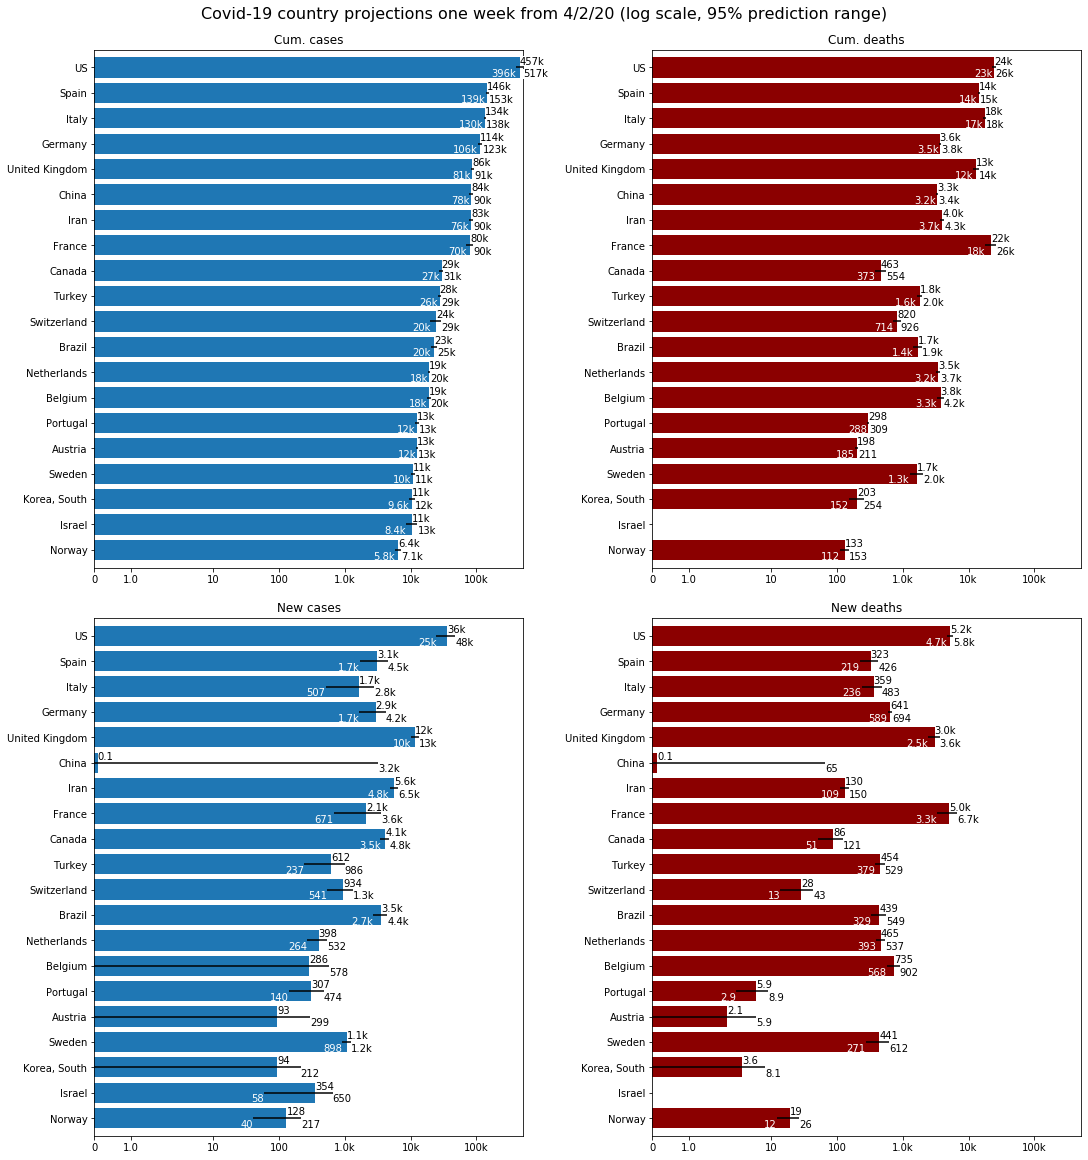

In [5]:
# Function families to apply in curve fitting
#############################################

# Exponential fit function
def fitExp(x, a, b):
    return a * np.exp(b*x)

# Generate a label for the exponential model
def fitExpLabeller(popt):
    return "f(t)=%ge^(%gt)" % (s3(popt[0]), s3(popt[1]))


# Derivative of the exponential fit function
def fitExpDerivative(x, a, b):
    return a * b * np.exp(b*x)

# Generate a label for the derivative of the exponential model
def fitExpDerivativeLabeller(popt):
    return "f(t)=%ge^(%gt)" % (s3(popt[0]*popt[1]), s3(popt[1]))


# Sigmoid model for fitting
def fitSig(t, a, b, c):
    return a/(1.0+np.exp(-b*t - c)) 

# Generate a label for the sigmoid model
def fitSigLabeller(popt):
    return "f(t)=%g \u03c3(%gt%+g)" % (s3(popt[0]), s3(popt[1]), s3(popt[2]))


# Derivative of the sigmoid fit function
def fitSigDerivative(t, a, b, c):
    s=fitSig(t,1,b,c)
    return a*b*s*(1-s)

# Generate a label for the derivative of the sigmoid model
def fitSigDerivativeLabeller(popt):
    return "f(t)=%g \u03c3'(%gt%+g)" % (s3(popt[0]*popt[1]), s3(popt[1]), s3(popt[2]) )


# Extended sigmoid fit function, with continued linear growth
def fitSigExt(t, a, b, c, n):
    return fitSig(t,a,b,c) + n*np.log(1+np.exp(b*t+c))

# Generate a label for the extended sigmoid fit model
def fitSigExtLabeller(popt):
    return "f(t)=%g \u03c3'(%gt%+g)\n%+g log(1+e^(%gt%+g))" % (s3(popt[0]), s3(-popt[1]), s3(-popt[2]), s3(popt[3]), s3(-popt[1]), s3(-popt[2]))

    
# Derivative of the extended sigmoid fit function, with continued flat tail
def fitSigExtDerivative(t, a, b, c, n):
    s=fitSig(t,1,b,c)
    return a*b*s*(1-s) + fitSig(t, n*b, b,c)

# Generate a label for the derivative of the extended sigmoid model
def fitSigExtDerivativeLabeller(popt):
    return "f(t)=%g \u03c3'(%gt%+g)\n%+g \u03c3(same)" % (s3(popt[0]*popt[1]), s3(-popt[1]), s3(-popt[2]), s3(popt[3]), )


# Curve fitting helpers
#######################

# For a given curve fit, calculate the conf% confidence and prediction bands.
# Confidence is for the true value. Prediction is for future measured values, including noise
# Inspired by https://stats.stackexchange.com/questions/15423/how-to-compute-prediction-bands-for-non-linear-regression
def calculateConfidenceAndPredictionBands(pxs, xs, ys, f, popt, pcov, conf=0.95):
    sumOfSquares=sum((ys-f(xs,*popt))**2)
    degreesOfFreedom=len(xs)-len(popt)
    alpha=1.0-conf
    criticalT = stats.t.ppf(1.0 - alpha / 2.0, degreesOfFreedom)
    
    pys=f(pxs, *popt)
    lpb, lcb, ucb, upb=[], [], [], []
    
    #print("Start fitting with criticalT=%g and dof=%g" % (criticalT, degreesOfFreedom))
    
    # for all predicted points
    grad=np.array([0]*len(popt))
    ptmp=popt.copy()
    epsilon=1e-8
    cs=[]
    confidences=[]
    predictions=[]
    for px, py in zip(pxs, pys):
       
        # calculate gradient for all parameter dimensions at this point
        for i in range(len(popt)):
            # Calculate numerical derivative of the best fit function w.r.t. parameter i
            epsilon=1e-4
            ptmp[i]=popt[i]-epsilon
            yl=f(px, *ptmp)
            ptmp[i]=popt[i]+epsilon
            yh=f(px, *ptmp)
            ptmp[i]=popt[i]
            grad[i]=(yh-yl)/(2.0*epsilon)
        
        # calculate variance of the best fit function based on the gradient and the covariance
        c=grad.dot(pcov.dot(grad.T))
        cs.append(c)
        
        # compute confidence and prediction intervals at this point
        confidence=criticalT*math.sqrt(c)
        prediction=criticalT*math.sqrt(c+sumOfSquares/degreesOfFreedom)
        confidences.append(confidence)
        predictions.append(prediction)
        
        lpb.append(py-prediction)
        lcb.append(py-confidence)
        ucb.append(py+confidence)
        upb.append(py+prediction)

    return lpb, lcb, pys, ucb, upb


# Fit country curves and generate summaries
###########################################

# Silently ignore optimize warnings when curve fitting
warnings.simplefilter("ignore", OptimizeWarning)
np.seterr(over='ignore')

# For all countries
topK=20
extDayCount=7
newCasesFits,  newCasesProj7,  newCasesProj7Low,  newCasesProj7High =[], [], [], []
cumCasesFits,  cumCasesProj7,  cumCasesProj7Low,  cumCasesProj7High =[], [], [], []
newDeathsFits, newDeathsProj7, newDeathsProj7Low, newDeathsProj7High=[], [], [], []
cumDeathsFits, cumDeathsProj7, cumDeathsProj7Low, cumDeathsProj7High=[], [], [], []
countryNamesSorted=[]
for cty in validCountries[:topK]:  #[{'Name':'France'},{'Name':'Iran'},{'Name':'Israel'},]: 
    countryName=cty['Name']
    countryNamesSorted.append(countryName)
    
    # For both series of data, cases and deaths
    seriesSets=[(confd, "Cases"), 
                (deaths, "Deaths")]
    for df, seriesName in seriesSets:
        xlabels, x, y=getData(df, countryName)
        yd= diff(y)
        n = len(yd)
        px       = np.linspace(x[0], x[-1]+extDayCount, 3*(len(x)+extDayCount)) # resample to make curves smoother
        pxlabels = [datetime.datetime.combine(xlabels[0],datetime.time(0,0,0))+datetime.timedelta(days=(d-x[0])) for d in px]

        # For all fitting functions, exponential, sigmoid etc., find best fit
        fitSets=[(0, fitExpDerivative, fitExpDerivativeLabeller, [0.1, 0.1],  fitExp, fitExpLabeller ), 
                 (1, fitSigDerivative, fitSigDerivativeLabeller, [max(yd), 0.1, -10],  fitSig, fitSigLabeller),
                 (2, fitSigExtDerivative, fitSigExtDerivativeLabeller, [max(yd), 0.1, -10, 10], fitSigExt, fitSigExtLabeller)]
        bestR2, bestR2Index, bestR2Popt, bestR2Pcov=0, None, [], []
        sndbestR2, sndbestR2Index, sndbestR2Popt, sndbestR2Pcov=0, None, [], []
        for index, f, fLabeller, p0, fInt, fIntLabeller in fitSets:
            try:
                popt, pcov = curve_fit(f, x, yd, p0)
                r2         = 1.0-(sum((yd-f(x,*(popt)))**2)/((n-1.0)*np.var(yd,ddof=1)))
                # pseudo-R2 for nonlinear fits, from https://stackoverflow.com/a/14530853
                # Or better use standard error of the estimate? Lower values are better
                # math.sqrt(sum((ys-f(x, *(popt)))**2)/(n-2.0))
                
                if abs(popt[1]>2): # PRIOR: we know the exponent is fairly small, use this to ignore absurd fits
                    continue
                    
                # make this the new best result, if it exceeds the previous one by a threshold
                # added cache in case an intermediate result was somewhat better, but the new one isn't much better
                epsilon=0.02
                if r2>bestR2+epsilon and r2>sndbestR2+epsilon:
                    bestR2, bestR2Index, bestR2Popt, bestR2Pcov=r2, index, popt, pcov
                    sndbestR2=0
                elif r2>bestR2+epsilon:
                    if sndbestR2>0:
                        bestR2, bestR2Index, bestR2Popt, bestR2Pcov=sndbestR2, sndbestR2Index, sndbestR2Popt, sndbestR2Pcov
                    sndbestR2, sndbestR2Index, sndbestR2Popt, sndbestR2Pcov=r2, index, popt, pcov
                    
            except (RuntimeError, OverflowError, TypeError) as e:
                continue

        r2, popt, pcov=bestR2, bestR2Popt, bestR2Pcov
        index, f, fLabeller, p0, fInt, fIntLabeller=fitSets[bestR2Index]

        # For both new and cumulative variants of each series
        newOrCumSets=[(yd, f,    fLabeller,    "New"), 
                      (y,  fInt, fIntLabeller, "Cum.")]
        for ys, f, fLabeller, newOrCum in newOrCumSets:
            # Fit data
            try:
                if newOrCum=='Cum.': # Recalculate R2 as the stored R2 was for new cases, not cumulative
                    r2 = 1.0-(sum((ys-f(x,*(popt)))**2)/((n-1.0)*np.var(ys,ddof=1)))
                    # pseudo-R2 for nonlinear fits, from https://stackoverflow.com/a/14530853
                    # Or better use standard error of the estimate? Lower values are better
                    # math.sqrt(sum((ys-f(x, *(popt)))**2)/(n-2.0))
                lpb, lcb, nom, ucb, upb=calculateConfidenceAndPredictionBands(px, x, ys, f, popt, pcov)
            except (RuntimeError, OverflowError, TypeError) as e:
                lpb, lcb, nom, ucb, upb=[math.nan], [math.nan], [math.nan], [math.nan], [math.nan], 

            # Store stats
            if seriesName=="Cases":
                if newOrCum=="New":
                    newCasesFits.append((f, fLabeller, popt, pcov, r2))
                    newCasesProj7.append(nom[-1])
                    newCasesProj7Low.append(lpb[-1])
                    newCasesProj7High.append(upb[-1])
                else:
                    cumCasesFits.append((f, fLabeller, popt, pcov, r2))
                    cumCasesProj7.append(nom[-1])
                    cumCasesProj7Low.append(lpb[-1])
                    cumCasesProj7High.append(upb[-1])
            else:
                if newOrCum=="New":
                    newDeathsFits.append((f, fLabeller, popt, pcov, r2))
                    newDeathsProj7.append(nom[-1])
                    newDeathsProj7Low.append(lpb[-1])
                    newDeathsProj7High.append(upb[-1])
                else:
                    cumDeathsFits.append((f, fLabeller, popt, pcov, r2))
                    cumDeathsProj7.append(nom[-1])
                    cumDeathsProj7Low.append(lpb[-1])
                    cumDeathsProj7High.append(upb[-1])

# Resort projections in rank order of confirmed cases
records=[(countryNamesSorted[i], \
          newCasesFits[i],  newCasesProj7[i],  newCasesProj7Low[i],  newCasesProj7High[i],  \
          cumCasesFits[i],  cumCasesProj7[i],  cumCasesProj7Low[i],  cumCasesProj7High[i],  \
          newDeathsFits[i], newDeathsProj7[i], newDeathsProj7Low[i], newDeathsProj7High[i], \
          cumDeathsFits[i], cumDeathsProj7[i], cumDeathsProj7Low[i], cumDeathsProj7High[i]) for i in range(len(countryNamesSorted))]

sortedRecords=sorted(records, key=operator.itemgetter(6), reverse=True)
for i in range(len(sortedRecords)):
    countryNamesSorted[i], \
    newCasesFits[i],  newCasesProj7[i],  newCasesProj7Low[i],  newCasesProj7High[i],  \
    cumCasesFits[i],  cumCasesProj7[i],  cumCasesProj7Low[i],  cumCasesProj7High[i],  \
    newDeathsFits[i], newDeathsProj7[i], newDeathsProj7Low[i], newDeathsProj7High[i], \
    cumDeathsFits[i], cumDeathsProj7[i], cumDeathsProj7Low[i], cumDeathsProj7High[i]=sortedRecords[i]

    
# Plot overview of country projections
######################################

fig, axs=plt.subplots(nrows=2, ncols=2, figsize=[15,16], constrained_layout=True)
fig.suptitle('Covid-19 country projections one week from %s (log scale, 95%% prediction range)' % today, fontsize="16")

low=0
high=max(cumCasesProj7High)

plotParams=[(axs[0][0], "Cum. cases", cumCasesProj7,  cumCasesProj7Low,  cumCasesProj7High,  "tab:blue", "w"),
            (axs[0][1], "Cum. deaths",cumDeathsProj7, cumDeathsProj7Low, cumDeathsProj7High, "darkred",  "w"),
            (axs[1][0], "New cases",  newCasesProj7,  newCasesProj7Low,  newCasesProj7High,  "tab:blue", "w"),
            (axs[1][1], "New deaths", newDeathsProj7, newDeathsProj7Low, newDeathsProj7High, "darkred",  "w"), ] 
for ax, title, proj, errLow, errHigh, barColor, fontColor in plotParams:
    ax.set_title(title)
    ax.set_xscale('symlog')
    ax.xaxis.set_major_formatter(hrFormatter)
    ax.invert_yaxis()
    ax.set_xlim(low, high)
    ax.margins(0.015)
    ax.barh(countryNamesSorted, proj, color=barColor, 
               xerr=(np.array(proj)-np.array(errLow), np.array(errHigh)-np.array(proj)) )
    
    for j, v in enumerate(errLow):
        if v>low:
            ax.text(v, j+0.25, humanReadable(v), ha='right', va='center', bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'), color=fontColor)
    for j, v in enumerate(errHigh):
        if v>low:
            ax.text(v, j+0.25, humanReadable(v), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

    # then label midpoint value
    for j, v in enumerate(proj):
        if v>low:
            ax.text(v, j-0.25, humanReadable(v), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))


Country projections are now based on fitting curves to the daily changes in cases and deaths. This removes a challenge with cumulative data: each cumulative data point is correlated with all previous data points. So fitting on the daily changes should result in better accuracy. These fits are transferred to the cumulative values by symbolic integration. 

To project current trends, we try and fit three families of curves: the derivative of an exponential, which is itself exponential; the derivative of a sigmoid, and the derivative of a sigmoid plus a sigmoid to simulate constant terminal growth. We select the value with the highest R^2. Such projections should be taken with a grain of salt, as both types of functions grow and diverge rapidly. 

The overview chart now shows 95% prediction ranges for the values. That is, 95% of future values on the given date, including measurement noise, should fall within the given error bound. These bounds have tightened as we now use the full covariance matrix, including correlations between different parameters. Confidence ranges for the underlying future value, i.e. without noise, are even tighter. Those are shown on the country details charts.

# Country Projection Details

As stated above, country projections are now based on fitting curves to the daily changes in cases and deaths. Charts now show both the 95% confidence intervals in blue shading, and 95% prediction intervals in blue dashes. The confidence interval means that the true value, without measurement noise, lies in that range. The prediction intervals mean that future data point measurements, including noise, will lie in that range.

The curve for Korea now includes a constant component for daily growth, which fits the data well. Intuitively, this term could represent a constant low level of new infections managed efficiently with rapid isolation, and/or a steady stream of false positives from ongoing mass testing.  

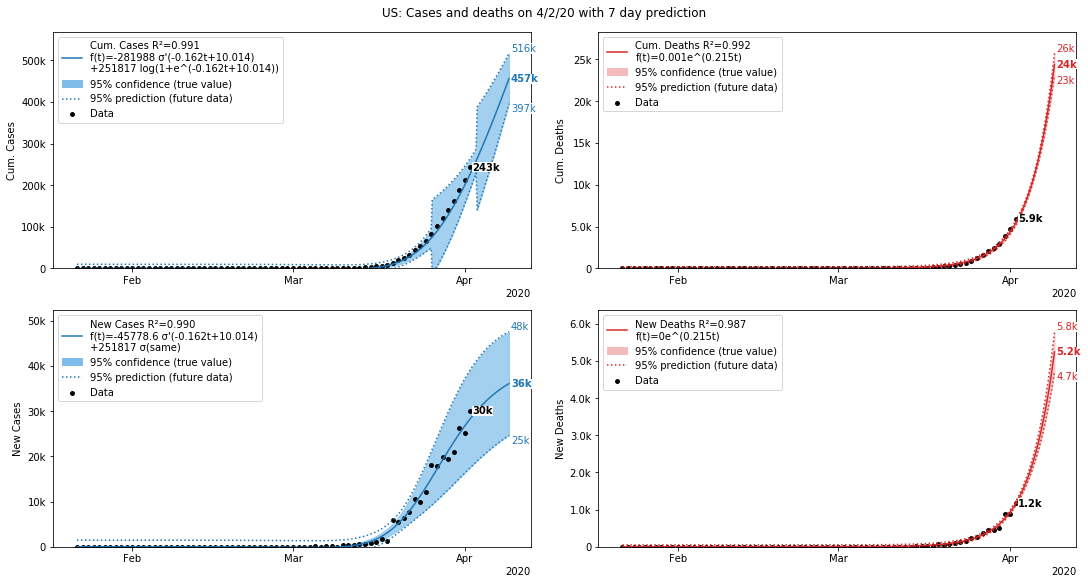

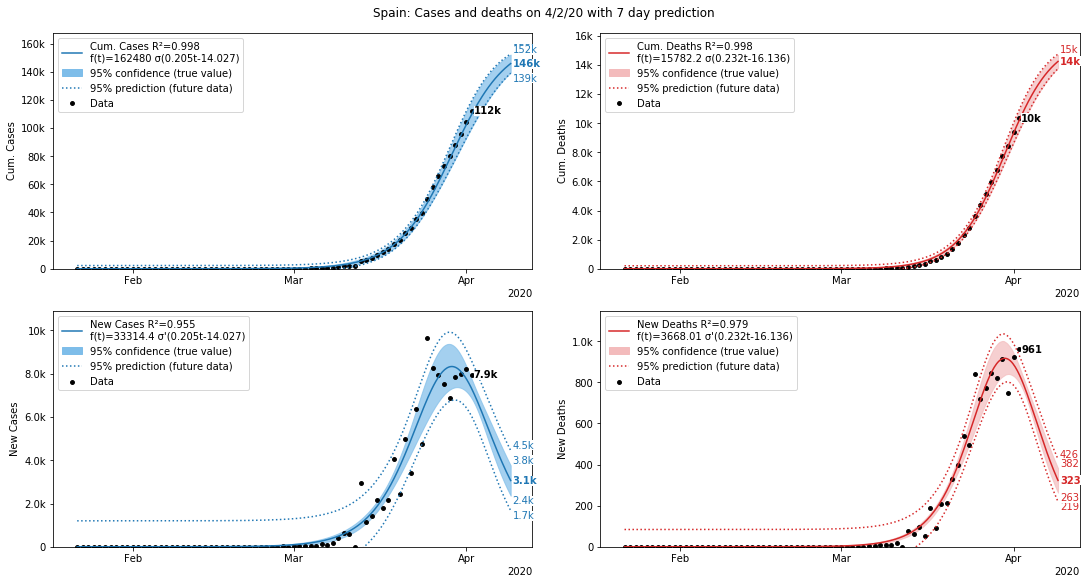

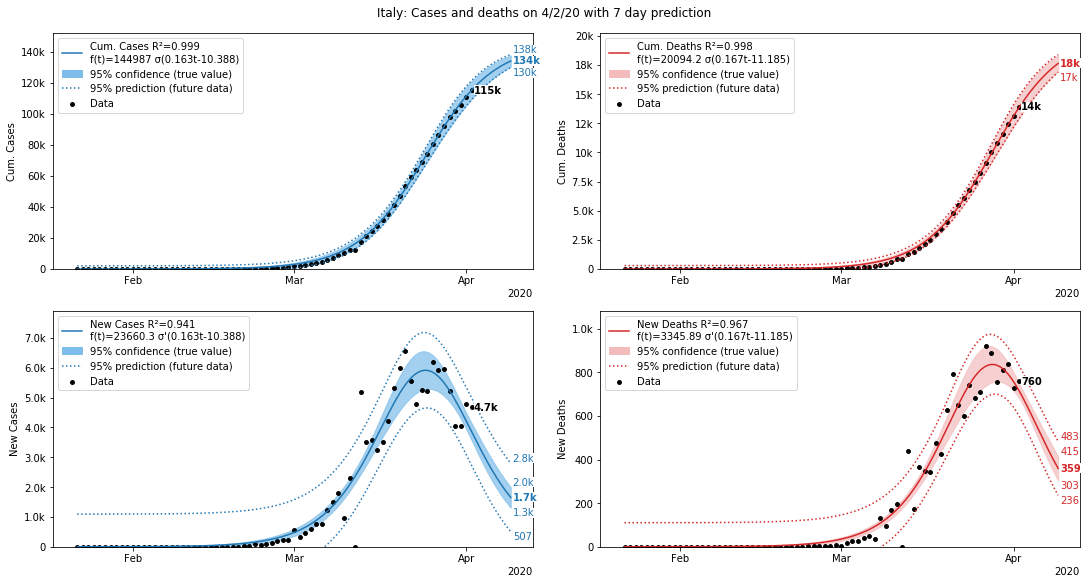

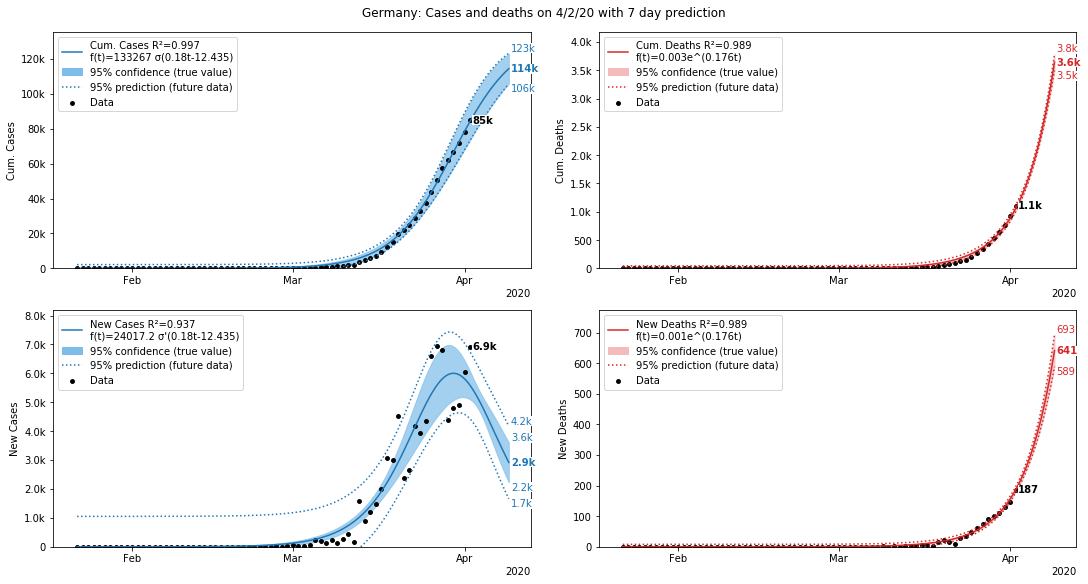

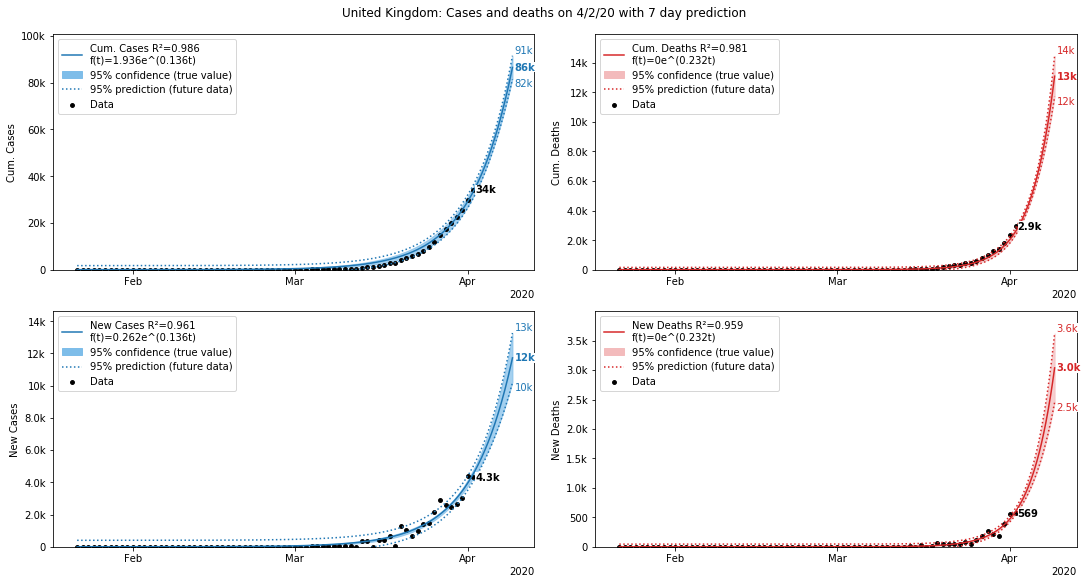

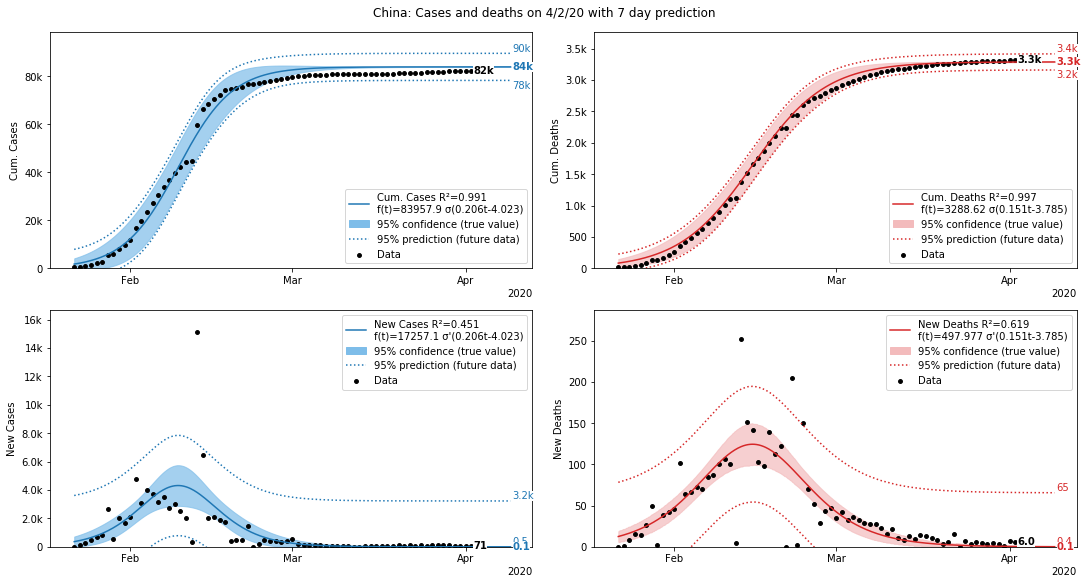

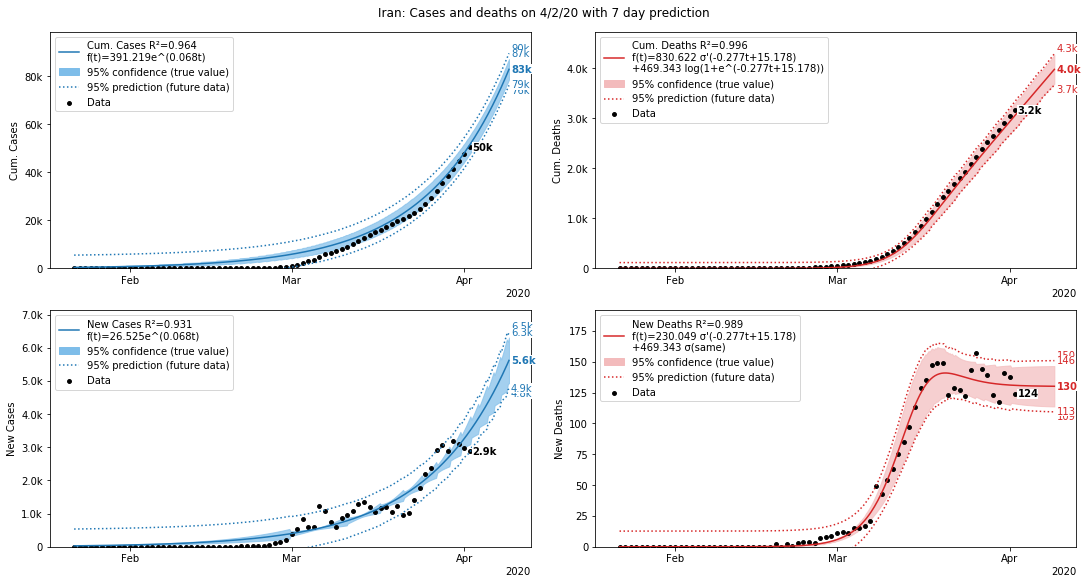

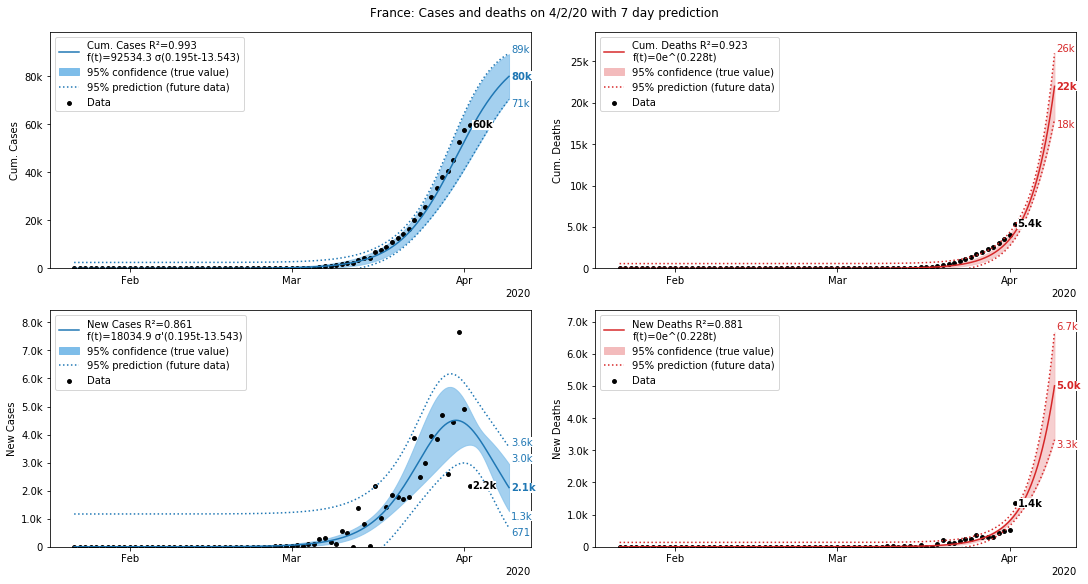

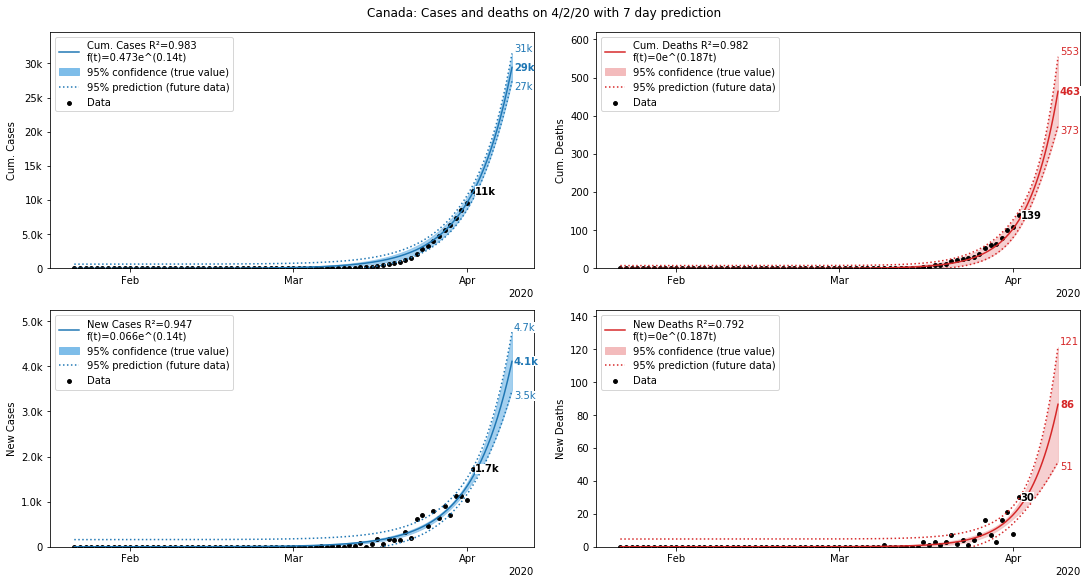

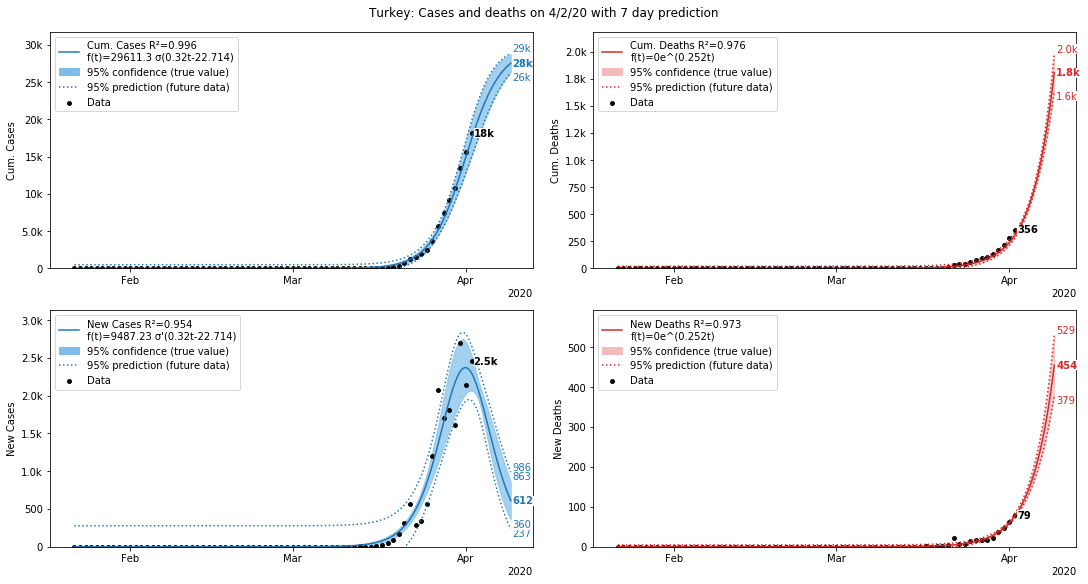

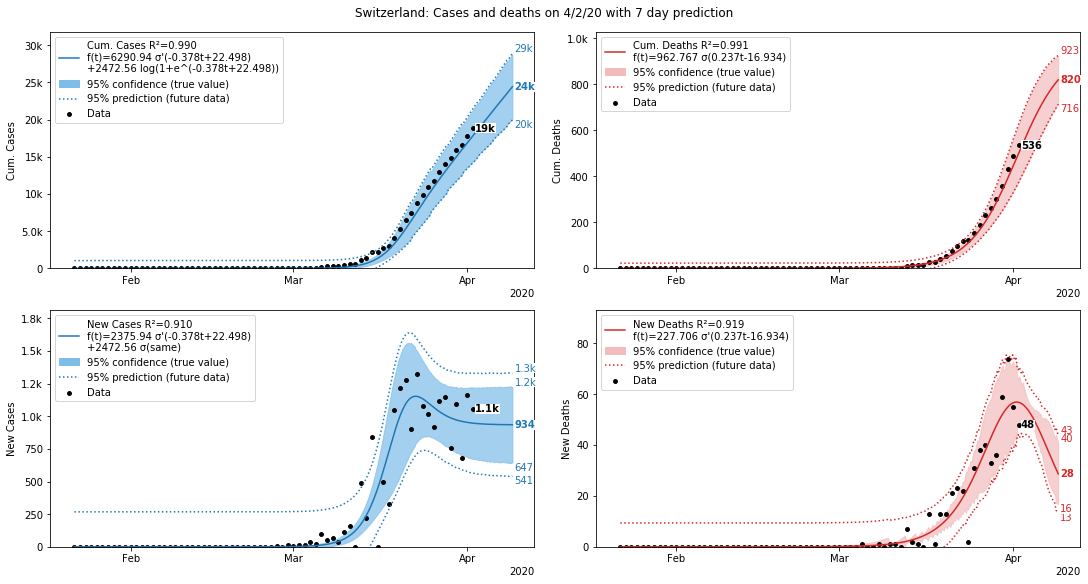

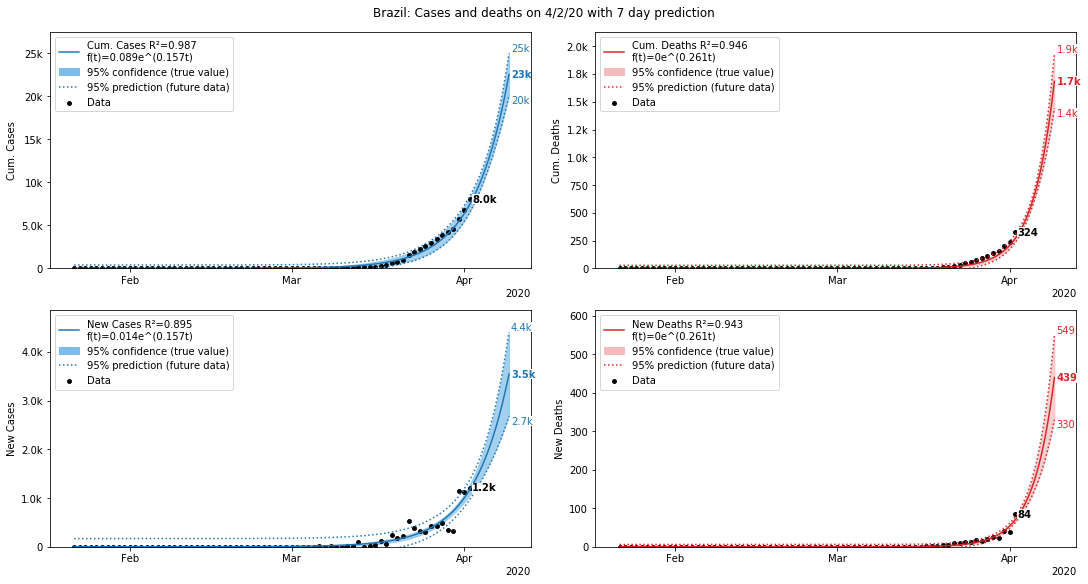

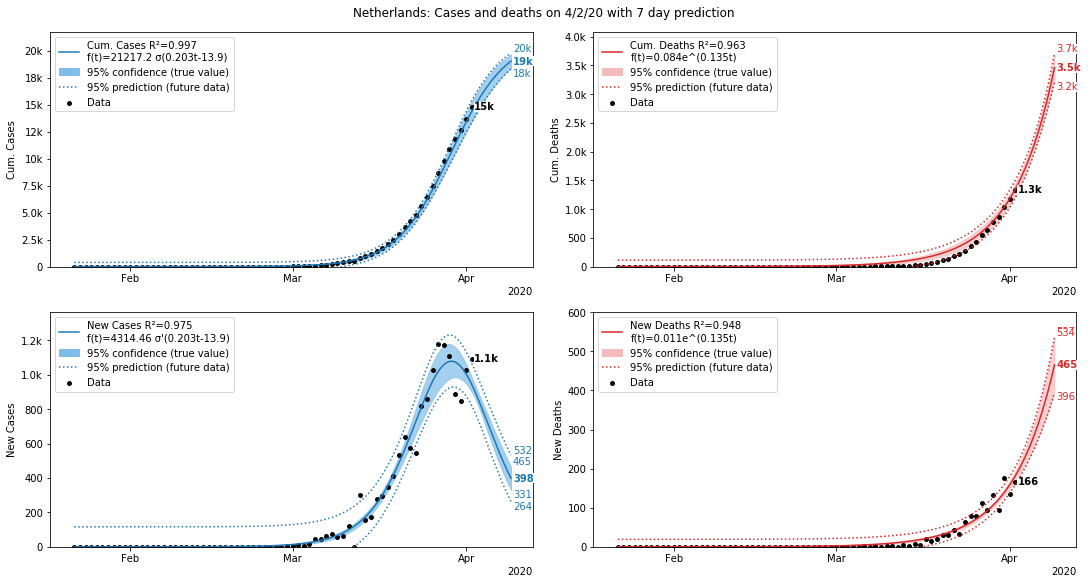

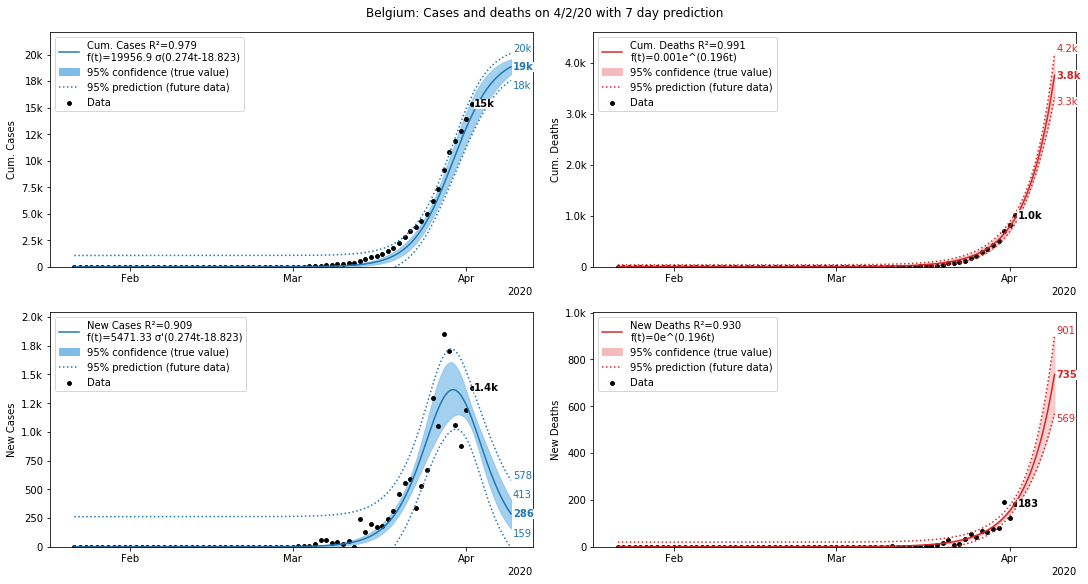

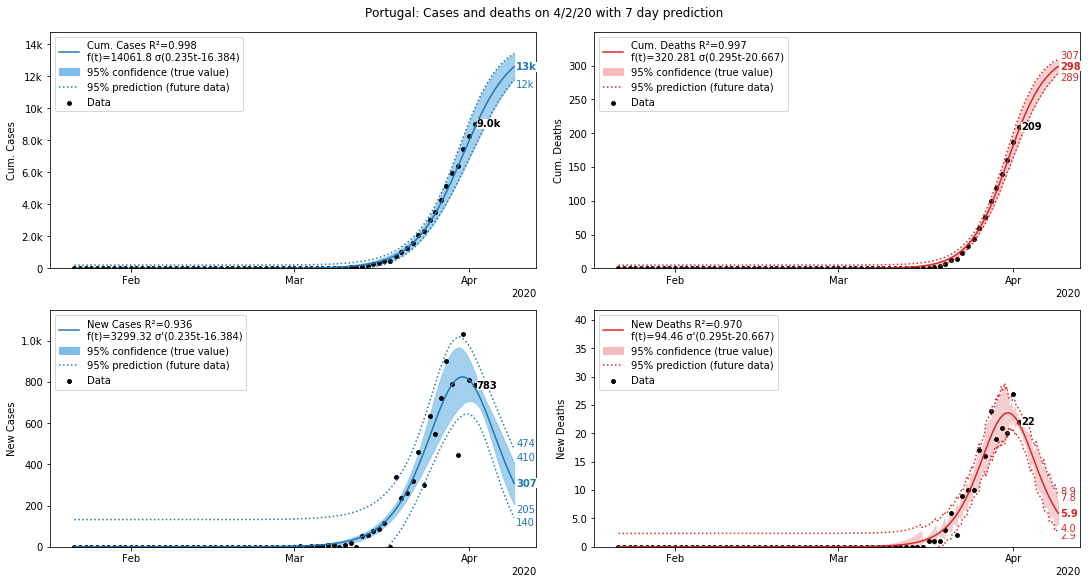

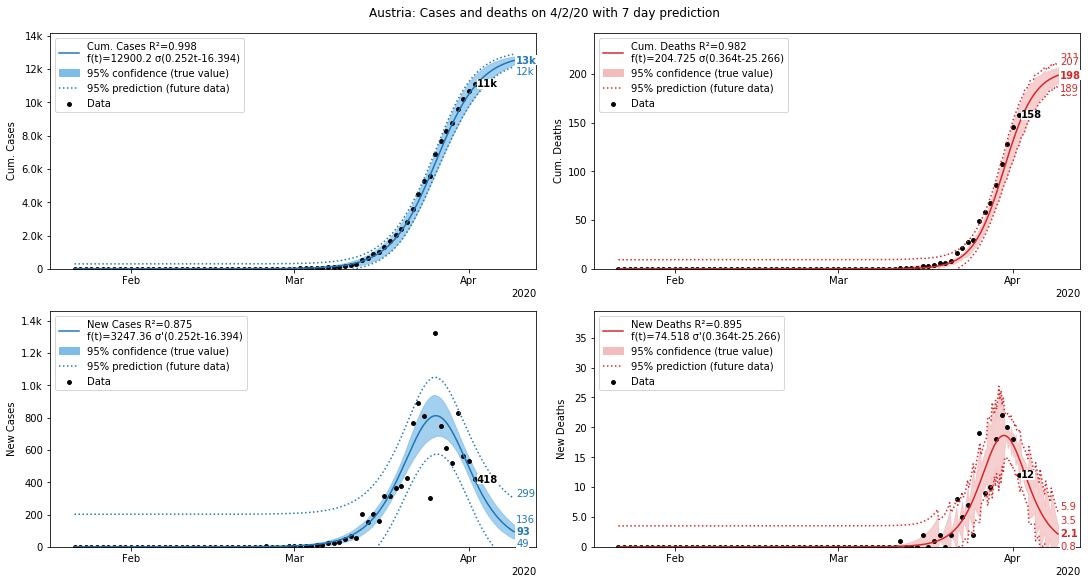

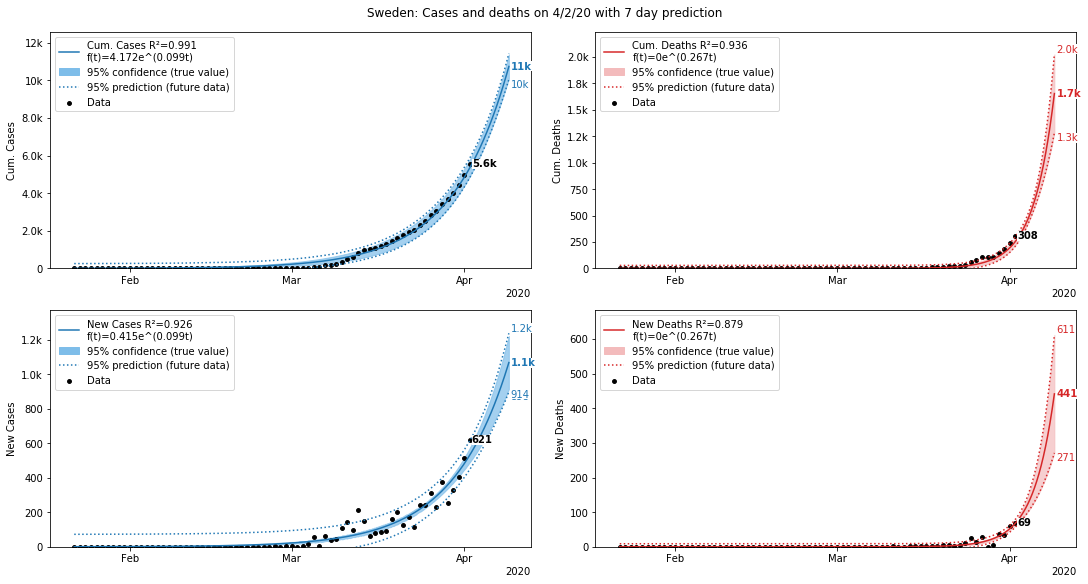

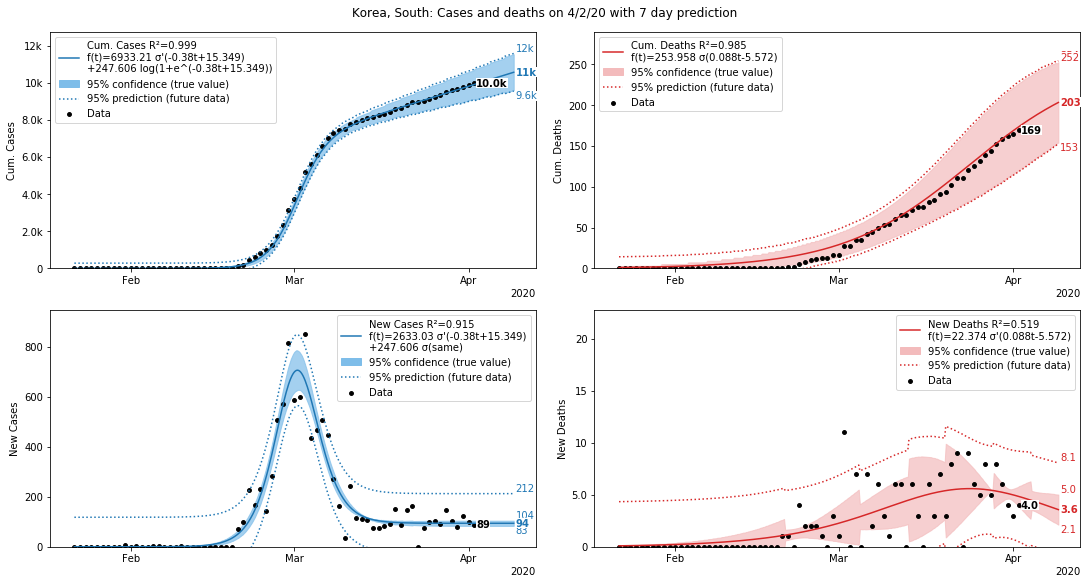

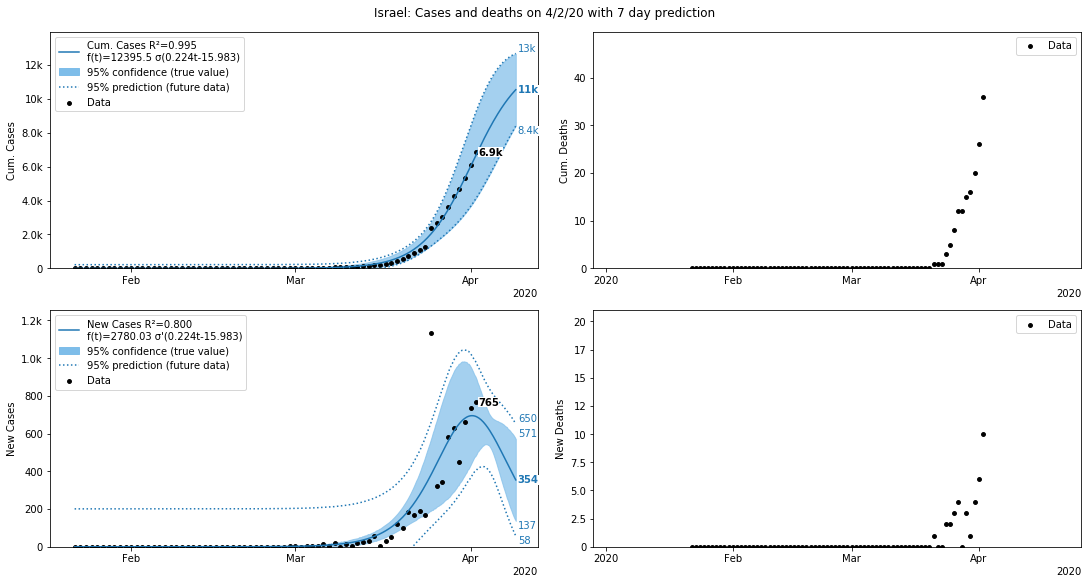

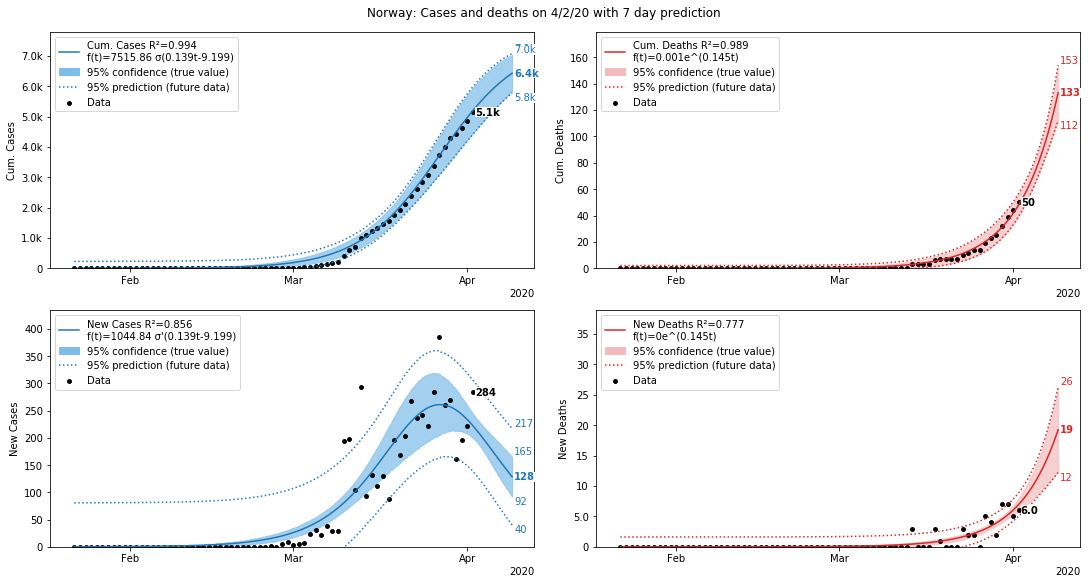

In [6]:
for i, countryName in enumerate(countryNamesSorted): 
    fig, axs=plt.subplots(figsize=[15, 8], nrows=2, ncols=2, constrained_layout=True)
    fig.suptitle('%s: Cases and deaths on %s with %d day prediction' % (countryName, today, extDayCount))

    seriesSets=[(axs[0][0], axs[1][0], confd,  "Cases",  "tab:blue"), 
                (axs[0][1], axs[1][1], deaths, "Deaths", "tab:red")]
    for ax1, ax2, df,seriesName, seriesColor in seriesSets:
        xlabels, x, y=getData(df, countryName)
        yd= diff(y)
        n = len(yd)

        px       = np.linspace(x[0], x[-1]+extDayCount, 5*(len(x)+extDayCount)) # resample to make curves smoother
        pxlabels = [datetime.datetime.combine(xlabels[0],datetime.time(0,0,0))+datetime.timedelta(days=(d-x[0])) for d in px]

        newOrCumSets=[(ax1, y,  "Cum."),
                    (ax2, yd, "New"), ]
        for ax, ys, newOrCum in newOrCumSets:
            if seriesName=="Cases":
                if newOrCum=="New":
                    f, fLabeller, popt, pcov, r2=newCasesFits[i]
                else:
                    f, fLabeller, popt, pcov, r2=cumCasesFits[i]
            else:
                if newOrCum=="New":
                    f, fLabeller, popt, pcov, r2=newDeathsFits[i]
                else:
                    f, fLabeller, popt, pcov, r2=cumDeathsFits[i]
                
            foundFit=0
            try:
                lpb, lcb, nom, ucb, upb=calculateConfidenceAndPredictionBands(px, x, ys, f, popt, pcov)
                foundFit=1
            except (RuntimeError, OverflowError, TypeError) as e:
                _
                
            if foundFit:
                # plot the prediction band (95% confidence)
                ax.plot(pxlabels, lpb, c=adjustLightness(seriesColor, 1.0), ls=':', label='95% prediction (future data)')
                ax.plot(pxlabels, upb, c=adjustLightness(seriesColor, 1.0), ls=':')

                # plot the confidence band (95%)
                ax.fill_between(pxlabels, lcb, ucb, color=adjustLightness(seriesColor, 1.7), alpha=0.7)
                fillBetweenLabel='95% confidence (true value)'
                fillBetweenPatch= mpatches.Patch(color=adjustLightness(seriesColor, 1.7), label=fillBetweenLabel)

                # plot the curve fit
                ax.plot(pxlabels, nom, c=seriesColor, label=newOrCum +' '+ seriesName + (" R\u00b2=%.3f\n" % r2)+ fLabeller(popt) )
                
            # plot raw data
            ax.scatter(xlabels, ys, s=15, label='Data', marker='o', c='k')

            if foundFit:
                # Label the bands in reverse order, avoiding duplicate labels
                if humanReadable(lpb[-1])!=humanReadable(nom[-1]):
                    labelLast(ax, pxlabels, lpb, c=seriesColor, va='top')
                if humanReadable(upb[-1])!=humanReadable(nom[-1]):
                    labelLast(ax, pxlabels, upb, c=seriesColor, va='bottom')
                if humanReadable(lcb[-1])!=humanReadable(nom[-1]) and humanReadable(lcb[-1])!=humanReadable(lpb[-1]):
                    labelLast(ax, pxlabels, lcb, c=seriesColor, va='top')
                if humanReadable(ucb[-1])!=humanReadable(nom[-1]) and humanReadable(ucb[-1])!=humanReadable(upb[-1]):
                    labelLast(ax, pxlabels, ucb, c=seriesColor, va='bottom')
                labelLast(ax, pxlabels, nom, c=seriesColor, weight='bold')
                labelLast(ax, xlabels, ys, c='k', weight='bold')

            # x axis formatting
            locator = mdates.AutoDateLocator(minticks=2, maxticks=4)
            formatter = mdates.ConciseDateFormatter(locator)
            ax.xaxis.set_major_locator(locator)
            ax.xaxis.set_major_formatter(formatter)

            # y axis formatting
            ax.set_ylabel(newOrCum+' '+seriesName)
            ax.yaxis.set_major_formatter(hrFormatter)
            if foundFit:
                ax.set_ylim(0, 1.1*max(max(ys), max(ucb), max(upb))+10) 
            else:
                ax.set_ylim(0, 1.1*max(ys)+10)
                
            if foundFit:
                # fix legend order
                handles, labels = ax.get_legend_handles_labels()
                handles.append(fillBetweenPatch)
                labels.append(fillBetweenLabel)
                order = [1,3,0,2]
                ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
            else:
                ax.legend()
            
    plt.show()

## Predicting new deaths from new cases

When the fitted curves for new cases and for new deaths both depart from the exponential, we can try and predict new deaths from new cases. Intuitively, this should be governed by the case fatality rate (CFR) and a time delay. As a formula, let's try and apply `predictedNewDeaths(t)=CFR * newCases(t - delay)`.

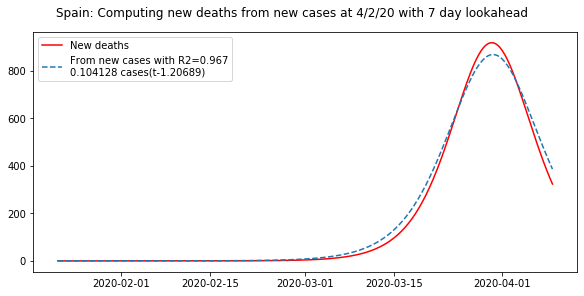

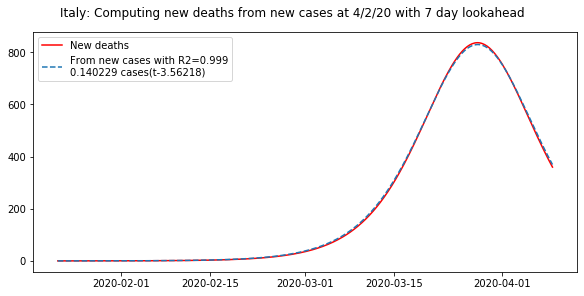

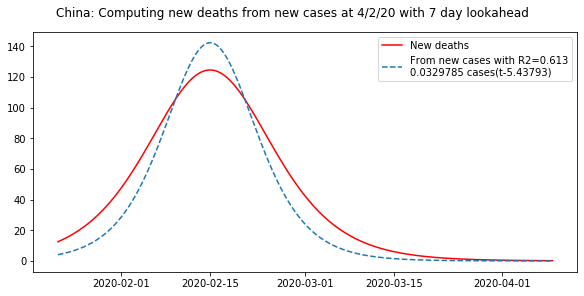

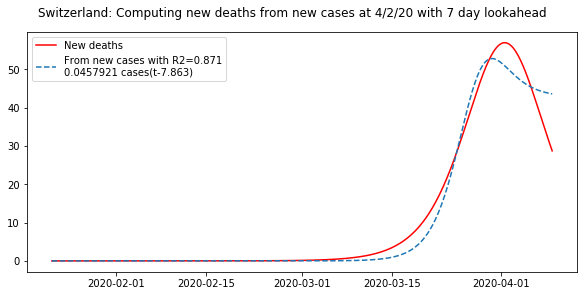

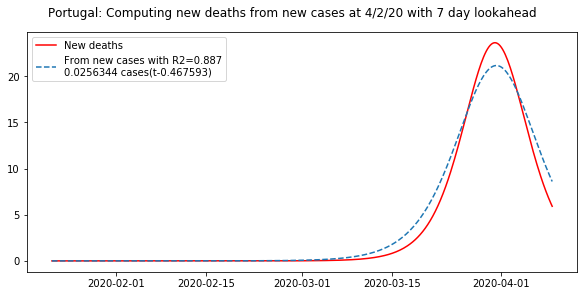

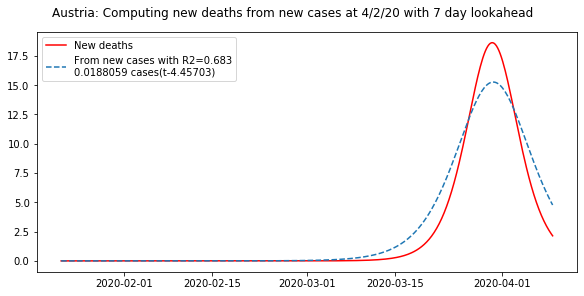

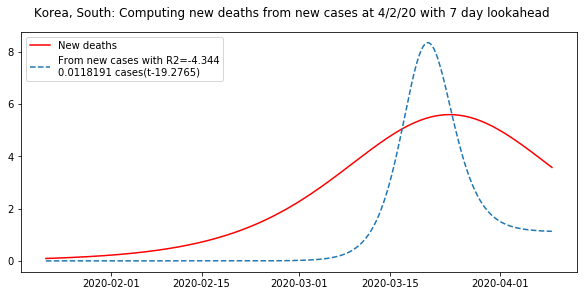

In [7]:
inferredNames, inferredCFRs, inferredDelays=[], [], []

for i, countryName in enumerate(countryNamesSorted): 
    cf, cfLabeller, cpopt, cpcov, cr2=newCasesFits[i]
    df, dfLabeller, dpopt, dpcov, dr2=newDeathsFits[i]
    
    # Skip countries still in exponential growth
    if cf==fitExpDerivative or df==fitExpDerivative:
        continue
    
    xlabels, x, y=getData(confd, countryName)
    yd= diff(y)
    n = len(yd)    
    
    px       = np.linspace(x[0], x[-1]+extDayCount, 5*(len(x)+extDayCount)) # resample to make curves smoother
    pxlabels = [datetime.datetime.combine(xlabels[0],datetime.time(0,0,0))+datetime.timedelta(days=(d-x[0])) for d in px]
    dpy      = df(px, *(dpopt))
    
    def fitdf(t, a, b):
        return a*cf(t-b, *(cpopt))
    
    try:
        popt, pcov =curve_fit(fitdf, px, dpy, [0.05, 10])
        sqdiff     = sum((dpy-fitdf(px,*(popt)))**2)
        r2         = 1.0-(sqdiff/((n-1.0)*np.var(dpy,ddof=1)))  
        # pseudo-R2 for nonlinear fits, from https://stackoverflow.com/a/14530853
        
    except (RuntimeError) as e:
        continue
    
    inferredNames.append(countryName)
    inferredCFRs.append(popt[0])
    inferredDelays.append(popt[1])
    
    dpyFromCases=fitdf(px, *(popt))
    fig, axs=plt.subplots(figsize=[8, 4], nrows=1, ncols=1, constrained_layout=True)
    fig.suptitle('%s: Computing new deaths from new cases at %s with %d day lookahead' % (countryName, today, extDayCount))
    axs.plot(pxlabels, dpy, label="New deaths", c="r")
    axs.plot(pxlabels, dpyFromCases, label="From new cases with R2=%.3f\n%g cases(t%+g)" % (r2, popt[0], -popt[1]), c="tab:blue", ls="--")
    axs.legend()
    plt.show()

For the countries where data is available, inferred CFRs and delays range widely.

Spain and Italy have short delay values and high CFRs in the 10-14% range. This could be an indication that cases are detected late, and therefore little time remains for curative measures. China, Austria, Switzerland and Portugal have medium CFRs in the 2-3% range. While Austria, Switzerland China also have medium delays of around 5.5, for Portugal the delay is again short (below a day). The fit for South Korea is not as good as for the others. But the country has the longest delay of some 20 days, and the lowest CFR of around 1% in this set. 

Treating Portugal as an outlier, a working hypothesis could be: identifying and treating cases early keeps fatalities lower.

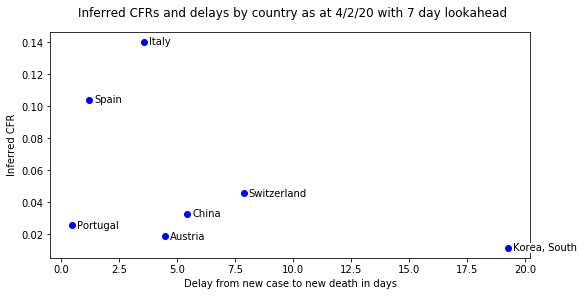

In [8]:
fig, axs=plt.subplots(figsize=[8, 4], nrows=1, ncols=1, constrained_layout=True)
fig.suptitle('Inferred CFRs and delays by country as at %s with %d day lookahead' % (today, extDayCount))
axs.plot(inferredDelays, inferredCFRs, "bo")
axs.set_xlabel("Delay from new case to new death in days")
axs.set_ylabel("Inferred CFR")
for name, delay, cfr in zip(inferredNames, inferredDelays, inferredCFRs):
    axs.annotate(name, (delay,cfr), (5,0), textcoords='offset pixels', ha='left', va="center", bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
plt.show()


Return to [daily series overview](https://mlnoga.github.io/covid19-analysis/). Data source: [Johns Hopkins](https://github.com/CSSEGISandData/COVID-19). For questions and comments, please reach out to me on [LinkedIn](https://www.linkedin.com/in/mlnoga/) or [Twitter](https://twitter.com/mlnoga).